#  Implementation of Adam Optimizer on Fashion MNIST model

In [1]:
from fashionmnist_model import FMM
from sklearn.model_selection import KFold

import tensorflow as tf

In [2]:
# Load the data
X_train, y_train, X_test, y_test = FMM.load_data()

In [3]:
X_train, X_test = FMM.reshape_data(X_train, X_test)

In [4]:
optimizer = tf.keras.optimizers.Adam()

In [5]:
# Create and compile the model with the optimizer
model = FMM.get_model()
print(f"Training with {optimizer.__class__.__name__} optimizer...")
history = FMM.compile_and_train(
    model, X_train, y_train, optimizer
)

Training with model model_v1 ...
Training with Adam optimizer...
Epoch 1/30


2024-02-23 22:03:18.865588: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


750/750 [==============================] - 1s 1ms/step - loss: 0.5282 - accuracy: 0.8146 - val_loss: 0.4417 - val_accuracy: 0.8402
Epoch 2/30
750/750 [==============================] - 1s 1ms/step - loss: 0.3776 - accuracy: 0.8651 - val_loss: 0.3621 - val_accuracy: 0.8652
Epoch 3/30
750/750 [==============================] - 1s 1ms/step - loss: 0.3351 - accuracy: 0.8777 - val_loss: 0.3689 - val_accuracy: 0.8683
Epoch 4/30
750/750 [==============================] - 1s 1ms/step - loss: 0.3115 - accuracy: 0.8855 - val_loss: 0.3450 - val_accuracy: 0.8752
Epoch 5/30
750/750 [==============================] - 1s 1ms/step - loss: 0.2953 - accuracy: 0.8899 - val_loss: 0.3239 - val_accuracy: 0.8808
Epoch 6/30
750/750 [==============================] - 1s 1ms/step - loss: 0.2784 - accuracy: 0.8963 - val_loss: 0.3519 - val_accuracy: 0.8718
Epoch 7/30
750/750 [==============================] - 1s 1ms/step - loss: 0.2668 - accuracy: 0.9010 - val_loss: 0.3350 - val_accuracy: 0.8839
Epoch 8/30
750/75

313/313 - 0s - loss: 0.4333 - accuracy: 0.8874 - 131ms/epoch - 419us/step

Training accuracy : 0.9543958306312561
Validation accuracy : 0.8929166793823242
Loss : 0.43329453468322754
Accuracy : 0.8873999714851379



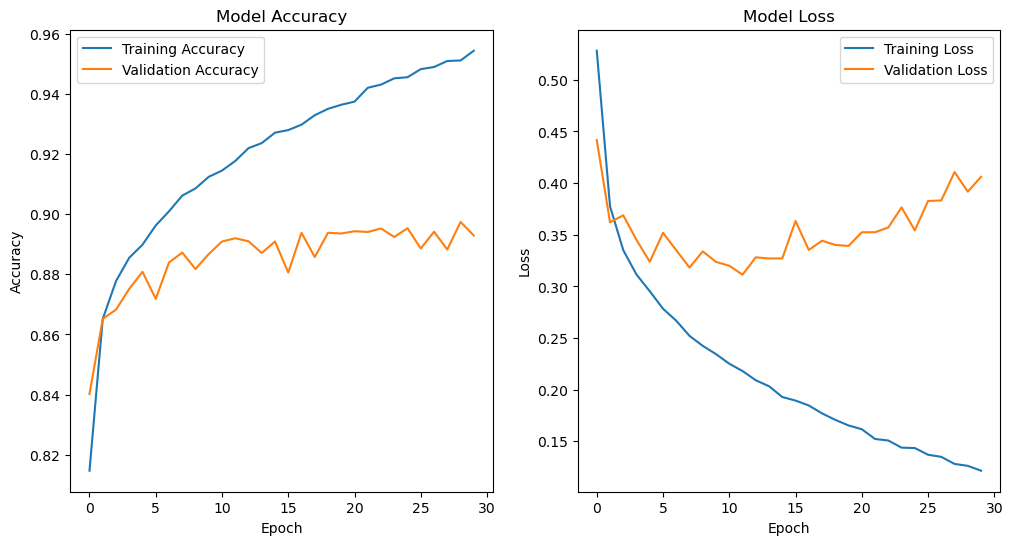

In [6]:
FMM.evaluate(model, X_test, y_test, history)
FMM.plot_history(history)

# Hyperparameter tunning

In [7]:
# ! pip install -U "ray[data,train,tune,serve]"

In [8]:
import ray
from ray import tune, train

In [9]:
ray.init()

2024-02-23 22:03:46,422	INFO worker.py:1715 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.11.5
Ray version:,2.9.2
Dashboard:,http://127.0.0.1:8265


In [10]:
# Define a function to train the model
def train_model(config, kf):
    from fashionmnist_model import FMM
    import tensorflow as tf
    import ray
    
    X_train, y_train, X_test, y_test = FMM.load_data()
    X_train, X_test = FMM.reshape_data(X_train, X_test)
    
    # Extract k-fold splits
    for train_index, val_index in kf.split(X_train):
        x_train_fold, x_val_fold = X_train[train_index], X_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
        
        # Define and compile the model
        model = FMM.get_model()
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=config["learning_rate"]
        )
        model.compile(optimizer=optimizer,
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        
        # Train the model
        history = model.fit(x_train_fold, y_train_fold,
                            validation_data=(x_val_fold, y_val_fold),
                            epochs=40, batch_size=64, verbose=0)
        
        # Evaluate the model
        loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
        
        # Report results
        train.report({"accuracy": accuracy, "loss":loss, "learning_rate":config["learning_rate"]})


In [11]:
search_space = { 
    "learning_rate": tune.grid_search([0.001, 0.0005, 0.0001]),
    # "beta_1": tune.grid_search([0.9, 0.95, 0.99]),
    # "beta_2": tune.grid_search([0.999, 0.9999]),
    # "epsilon": tune.grid_search([1e-8, 1e-7, 1e-6]),
    # "weight_decay": tune.grid_search([1e-6, 1e-5, 1e-4]),
}

In [12]:
analysis = tune.run(
    lambda config: train_model(config, KFold(n_splits=5)),
    config=search_space,
    metric="accuracy",
    mode="max",
    num_samples=3
)

2024-02-23 22:03:46,920	INFO tune.py:583 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


(raylet) [2024-02-23 22:03:55,338 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 10856394752; capacity: 245107195904. Object creation will fail if spilling is required.


(<lambda> pid=75377) Training with model model_v1 ...


(<lambda> pid=75371) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
(<lambda> pid=75374) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.
(<lambda> pid=75371) 2024-02-23 22:03:59.659314: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
(raylet) [2024-02-23 22:04:05,344 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 7629582336; capacity: 245107195904. Object creation will fail if spilling is required.
(<lambda> pid=75372) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.ker

Trial name,accuracy,learning_rate,loss
lambda_53aa6_00000,0.8845,0.001,0.529798
lambda_53aa6_00001,0.8902,0.0005,0.474096
lambda_53aa6_00002,0.884,0.0001,0.338911
lambda_53aa6_00003,0.8873,0.001,0.514955
lambda_53aa6_00004,0.8841,0.0005,0.459115
lambda_53aa6_00005,0.8889,0.0001,0.327578
lambda_53aa6_00006,0.8904,0.001,0.530118
lambda_53aa6_00007,0.8895,0.0005,0.455842
lambda_53aa6_00008,0.8902,0.0001,0.331877


(<lambda> pid=75370) Training with model model_v1 ... [repeated 8x across cluster]


(<lambda> pid=75370) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
(<lambda> pid=75370) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.
(raylet) [2024-02-23 22:07:06,722 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 6548242432; capacity: 245107195904. Object creation will fail if spilling is required.
(<lambda> pid=75373) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`. [repeated 7x across cluster]
(<lambda> pid=75376) WARNING:absl:There is a known slowdown when using v2.11+ Keras 

(<lambda> pid=75375) Training with model model_v1 ... [repeated 8x across cluster]


(<lambda> pid=75373) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
(<lambda> pid=75373) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.
(raylet) [2024-02-23 22:10:18,024 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 4146872320; capacity: 245107195904. Object creation will fail if spilling is required.


(<lambda> pid=75372) 


(<lambda> pid=75372) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`. [repeated 7x across cluster]
(<lambda> pid=75372) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`. [repeated 7x across cluster]
(raylet) [2024-02-23 22:10:28,031 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 5454958592; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-23 22:10:38,128 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 5457358848; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2

(<lambda> pid=75375) Training with model model_v1 ... [repeated 8x across cluster]


(<lambda> pid=75375) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
(<lambda> pid=75375) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.


(<lambda> pid=75377) Training with model model_v1 ... [repeated 2x across cluster]


(<lambda> pid=75372) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`. [repeated 2x across cluster]
(<lambda> pid=75373) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.
(<lambda> pid=75371) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.
(raylet) [2024-02-23 22:13:39,369 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 4364283904; capacity: 245107195904. Object creation will fail if spilling is required.


(<lambda> pid=75376) Training with model model_v1 ... [repeated 5x across cluster]


(<lambda> pid=75376) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`. [repeated 5x across cluster]
(<lambda> pid=75376) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`. [repeated 5x across cluster]
(raylet) [2024-02-23 22:13:49,373 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 4364189696; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-23 22:13:59,471 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 6516645888; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2

(<lambda> pid=75375) Training with model model_v1 ...


(<lambda> pid=75375) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
(<lambda> pid=75375) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.


(<lambda> pid=75373) Training with model model_v1 ...


(<lambda> pid=75373) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
(<lambda> pid=75373) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.
(raylet) [2024-02-23 22:16:40,650 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 6513688576; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-23 22:16:50,763 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 6513512448; capacity: 245107195904. Object creation will fail if spilling is required.
(<lambda> pid=75372) WARNING:absl:At this time, the v2.11+ optimizer 

(<lambda> pid=75372) Training with model model_v1 ...
(<lambda> pid=75374) Training with model model_v1 ...


(<lambda> pid=75374) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
(<lambda> pid=75374) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.
(<lambda> pid=75371) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
(<lambda> pid=75371) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.


(<lambda> pid=75377) 


(raylet) [2024-02-23 22:17:00,869 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 5437235200; capacity: 245107195904. Object creation will fail if spilling is required.
(<lambda> pid=75376) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`. [repeated 3x across cluster]
(<lambda> pid=75376) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`. [repeated 3x across cluster]
(raylet) [2024-02-23 22:17:10,973 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 5437018112; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2

(<lambda> pid=75375) Training with model model_v1 ... [repeated 5x across cluster]


(<lambda> pid=75375) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
(<lambda> pid=75375) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.
(raylet) [2024-02-23 22:19:51,792 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 6515265536; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-23 22:20:01,878 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 6511497216; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-23 22:20:11,955 E 75354 1102666] (raylet) file_syst

(<lambda> pid=75375) Training with model model_v1 ...


(<lambda> pid=75375) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
(<lambda> pid=75375) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.
(raylet) [2024-02-23 22:20:42,129 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 9765715968; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-23 22:20:52,229 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 9766576128; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-23 22:21:02,230 E 75354 1102666] (raylet) file_syst

(<lambda> pid=75375) Training with model model_v1 ...


(<lambda> pid=75375) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
(<lambda> pid=75375) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.
(raylet) [2024-02-23 22:21:12,230 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 9765941248; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-23 22:21:22,231 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 9769111552; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-23 22:21:32,232 E 75354 1102666] (raylet) file_syst

(<lambda> pid=75375) Training with model model_v1 ...


(<lambda> pid=75375) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
(<lambda> pid=75375) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.
(raylet) [2024-02-23 22:21:42,332 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 9768656896; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-23 22:21:52,333 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 9768804352; capacity: 245107195904. Object creation will fail if spilling is required.


(<lambda> pid=75375) Training with model model_v1 ...


(<lambda> pid=75375) WARNING:absl:At this time, the v2.11+ optimizer `tf.keras.optimizers.Adam` runs slowly on M1/M2 Macs, please use the legacy Keras optimizer instead, located at `tf.keras.optimizers.legacy.Adam`.
(<lambda> pid=75375) WARNING:absl:There is a known slowdown when using v2.11+ Keras optimizers on M1/M2 Macs. Falling back to the legacy Keras optimizer, i.e., `tf.keras.optimizers.legacy.Adam`.
(raylet) [2024-02-23 22:22:02,336 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 9768767488; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-23 22:22:12,436 E 75354 1102666] (raylet) file_system_monitor.cc:111: /tmp/ray/session_2024-02-23_22-03-43_608160_75331 is over 95% full, available space: 9768751104; capacity: 245107195904. Object creation will fail if spilling is required.
(raylet) [2024-02-23 22:22:22,536 E 75354 1102666] (raylet) file_syst

In [13]:
ray.shutdown()

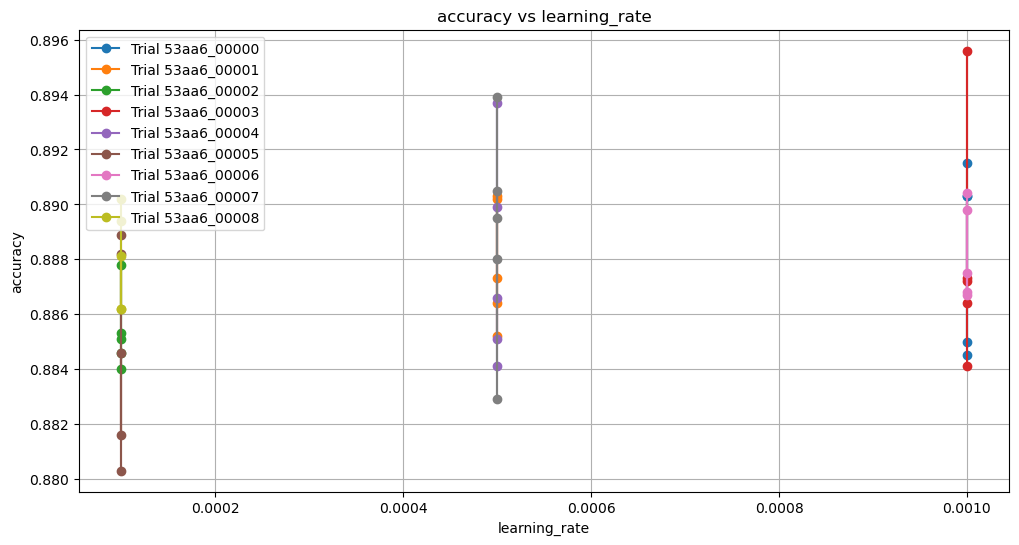

In [14]:
FMM.plot_analysis_results(analysis, x_axis="learning_rate", y_axis="accuracy")

In [15]:
# Print the best hyperparameters and results
best_config = analysis.best_config
print("Best hyperparameters:", best_config)
print("Best accuracy:", analysis.best_result["accuracy"])

Best hyperparameters: {'learning_rate': 0.001}
Best accuracy: 0.8903999924659729


In [16]:
optimizer = tf.keras.optimizers.Adam(**best_config)
model = FMM.get_model()
print(f"Training with {optimizer.__class__.__name__} optimizer...")
history = FMM.compile_and_train(
    model, X_train, y_train, optimizer
)

Training with model model_v1 ...
Training with Adam optimizer...
Epoch 1/30
750/750 [==============================] - 1s 1ms/step - loss: 0.5203 - accuracy: 0.8170 - val_loss: 0.4140 - val_accuracy: 0.8513
Epoch 2/30
750/750 [==============================] - 1s 1ms/step - loss: 0.3776 - accuracy: 0.8632 - val_loss: 0.3846 - val_accuracy: 0.8655
Epoch 3/30
750/750 [==============================] - 1s 1ms/step - loss: 0.3377 - accuracy: 0.8765 - val_loss: 0.3576 - val_accuracy: 0.8732
Epoch 4/30
750/750 [==============================] - 1s 1ms/step - loss: 0.3113 - accuracy: 0.8856 - val_loss: 0.3266 - val_accuracy: 0.8834
Epoch 5/30
750/750 [==============================] - 1s 1ms/step - loss: 0.2933 - accuracy: 0.8933 - val_loss: 0.3377 - val_accuracy: 0.8808
Epoch 6/30
750/750 [==============================] - 1s 1ms/step - loss: 0.2781 - accuracy: 0.8952 - val_loss: 0.3364 - val_accuracy: 0.8817
Epoch 7/30
750/750 [==============================] - 1s 1ms/step - loss: 0.2628 - 

313/313 - 0s - loss: 0.4598 - accuracy: 0.8889 - 141ms/epoch - 452us/step

Training accuracy : 0.9540208578109741
Validation accuracy : 0.893916666507721
Loss : 0.4598398506641388
Accuracy : 0.8888999819755554



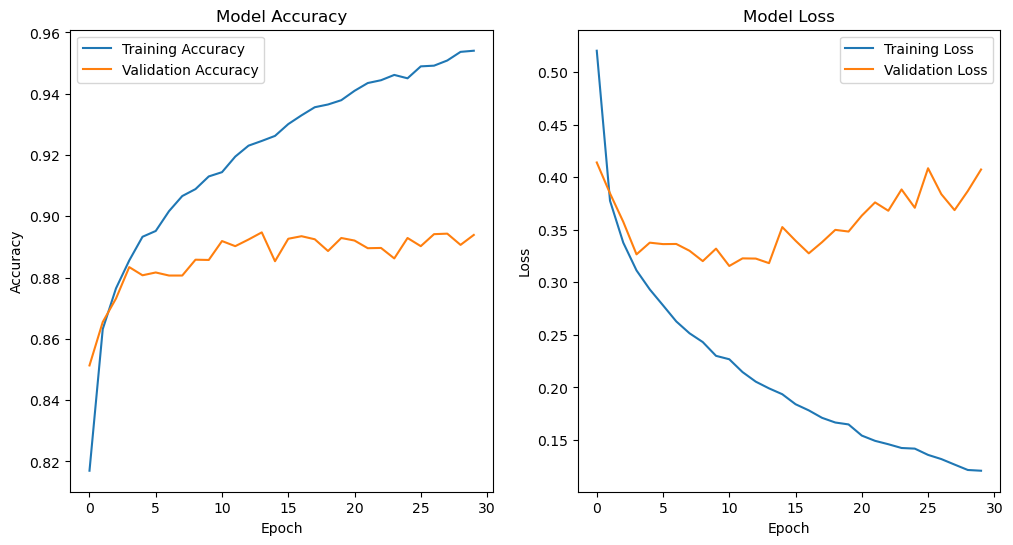

In [17]:
FMM.evaluate(model, X_test, y_test, history)
FMM.plot_history(history)